In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

from pytorch_sklearn.neural_network.neural_network import NeuralNetwork
from pytorch_sklearn.neural_network.generative_network import CycleGAN
from pytorch_sklearn.callbacks.predefined import Verbose, History, EarlyStopping
from pytorch_sklearn.utils.progress_bar import print_progress

In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return self.conv3(x)
    
class SimpleDiscriminator(nn.Module):
    def __init__(self):
        super(SimpleDiscriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=4)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=4)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = F.relu(self.maxpool1(self.conv1(x)))
        x = F.relu(self.maxpool2(self.conv2(x)))
        x = self.maxpool3(self.conv3(x))
        return x.view(-1, 1)

In [3]:
model = SimpleDiscriminator()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
crit = nn.MSELoss()

In [4]:
X = torch.randn(10, 3, 32, 32)
y = torch.randn(10, 1)

In [5]:
net = NeuralNetwork(model, optim, crit)

In [6]:
net.fit(
    train_X=X,
    train_y=y,
    max_epochs=50,
    callbacks=[Verbose(notebook=True)],
    metrics={'l1loss': nn.L1Loss(), 'l2loss': nn.MSELoss()},
)

Epoch 1/50
1/1 [====================] - train_loss: 0.682 - train_l1loss: 0.678 - train_l2loss: 0.682 - Time: 0.45 - ETA: 0.00
Epoch 2/50
1/1 [====================] - train_loss: 0.535 - train_l1loss: 0.574 - train_l2loss: 0.535 - Time: 0.01 - ETA: 0.00
Epoch 3/50
1/1 [====================] - train_loss: 0.467 - train_l1loss: 0.514 - train_l2loss: 0.467 - Time: 0.01 - ETA: 0.00
Epoch 4/50
1/1 [====================] - train_loss: 0.474 - train_l1loss: 0.522 - train_l2loss: 0.474 - Time: 0.01 - ETA: 0.00
Epoch 5/50
1/1 [====================] - train_loss: 0.467 - train_l1loss: 0.527 - train_l2loss: 0.467 - Time: 0.00 - ETA: 0.00
Epoch 6/50
1/1 [====================] - train_loss: 0.429 - train_l1loss: 0.498 - train_l2loss: 0.429 - Time: 0.01 - ETA: 0.00
Epoch 7/50
1/1 [====================] - train_loss: 0.389 - train_l1loss: 0.462 - train_l2loss: 0.389 - Time: 0.00 - ETA: 0.00
Epoch 8/50
1/1 [====================] - train_loss: 0.365 - train_l1loss: 0.460 - train_l2loss: 0.365 - Time: 0

In [7]:
net.predict(X)

tensor([[-0.4190],
        [ 0.7362],
        [-1.9413],
        [ 0.6315],
        [-0.8139],
        [-0.5805],
        [-0.5343],
        [-0.9665],
        [-0.0397],
        [-0.1518]], device='cuda:0')

In [16]:
class CycleGANDataset(Dataset):
    def __init__(self):
        self.A = torch.randn(10, 3, 32, 32) * .1
        self.B = torch.randn(10, 3, 32, 32) * .8

    def __len__(self):
        return 10
    
    def __getitem__(self, index):
        return self.A[index], self.B[index]

In [20]:
class STDMetric:
    def __init__(self):
        self.stdA = []
        self.stdB = []
        self.stdA2B = []
        self.stdB2A = []

    def __call__(self, batch_out, batch_y):
        A2B, B2A = batch_out
        A, B = batch_y
        self.stdA.append(A.std().item())
        self.stdB.append(B.std().item())
        self.stdA2B.append(A2B.std().item())
        self.stdB2A.append(B2A.std().item())
        return 0

In [17]:
G_A = SimpleCNN()
G_B = SimpleCNN()
D_A = SimpleDiscriminator()
D_B = SimpleDiscriminator()

G_optim = torch.optim.Adam(list(G_A.parameters()) + list(G_B.parameters()), lr=0.001)
D_optim = torch.optim.Adam(list(D_A.parameters()) + list(D_B.parameters()), lr=0.001)

In [18]:
cycle_gan = CycleGAN(G_A, G_B, D_A, D_B, G_optim, D_optim)

In [19]:
cycle_gan_ds = CycleGANDataset()

In [21]:
std_metric = STDMetric()

In [31]:
cycle_gan.fit(
    train_X=cycle_gan_ds,
    max_epochs=100,
    callbacks=[Verbose(notebook=True)],
    metrics={'std': std_metric},
)

Epoch 601/700
1/1 [====================] - train_loss: 4.695 - train_std: 0.000 - Time: 0.02 - ETA: 0.00
Epoch 602/700
1/1 [====================] - train_loss: 4.710 - train_std: 0.000 - Time: 0.02 - ETA: 0.00
Epoch 603/700
1/1 [====================] - train_loss: 4.727 - train_std: 0.000 - Time: 0.03 - ETA: 0.00
Epoch 604/700
1/1 [====================] - train_loss: 4.738 - train_std: 0.000 - Time: 0.02 - ETA: 0.00
Epoch 605/700
1/1 [====================] - train_loss: 4.717 - train_std: 0.000 - Time: 0.02 - ETA: 0.00
Epoch 606/700
1/1 [====================] - train_loss: 4.706 - train_std: 0.000 - Time: 0.02 - ETA: 0.00
Epoch 607/700
1/1 [====================] - train_loss: 4.706 - train_std: 0.000 - Time: 0.03 - ETA: 0.00
Epoch 608/700
1/1 [====================] - train_loss: 4.708 - train_std: 0.000 - Time: 0.02 - ETA: 0.00
Epoch 609/700
1/1 [====================] - train_loss: 4.712 - train_std: 0.000 - Time: 0.03 - ETA: 0.00
Epoch 610/700
1/1 [====================] - train_loss: 

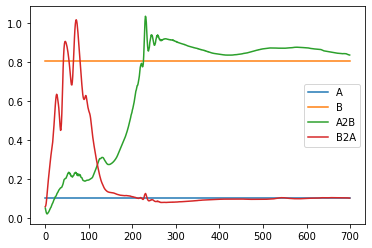

In [32]:
plt.plot(std_metric.stdA, label='A')
plt.plot(std_metric.stdB, label='B')
plt.plot(std_metric.stdA2B, label='A2B')
plt.plot(std_metric.stdB2A, label='B2A')
plt.legend()
plt.show()